In [24]:
from tomoSegmentPipeline.utils.common import read_array, write_array
from tomoSegmentPipeline.utils import setup
from cryoS2Sdrop.predict import load_model


from pytorch_msssim import ssim
from torchmetrics.functional import peak_signal_noise_ratio, mean_squared_error
import torch

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from glob import glob
import os
import yaml
# from itables import init_notebook_mode
# init_notebook_mode(all_interactive=True)

PARENT_PATH = setup.PARENT_PATH

pd.options.display.float_format = "{:,.4f}".format
pd.set_option('display.max_columns', 50)

%matplotlib inline
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
def standardize(X: torch.tensor):
    mean = X.mean()
    std = X.std()
    new_X = (X - mean) / std

    return new_X

def clip(X, low=0.005, high=0.995):
    # works with tensors =)
    return np.clip(X, np.quantile(X, low), np.quantile(X, high))

def get_metrics(tomo_path, gt_tomo_path, use_deconv_data):
    
    n2v_psnr, n2v_ssim_idx = None, None
    
    if use_deconv_data=='true':
        use_deconv_data=True
    elif use_deconv_data=='false':
        use_deconv_data=False
    
    if (tomo_path is not None) and (gt_tomo_path is not None):       
        try:
            gt_data = read_array(gt_tomo_path)
            gt_data = torch.tensor(gt_data).unsqueeze(0).unsqueeze(0)
            gt_data = standardize(clip(gt_data))
            
            if use_deconv_data:
                name = tomo_path.split('/')[-1].replace('.mrc', '_deconv_n2vDenoised.mrc')
            else:
                name = tomo_path.split('/')[-1].replace('.mrc', '_n2vDenoised.mrc')
            n2v_pred_path = os.path.join(PARENT_PATH, "data/S2SDenoising/denoised/%s" % (name))
            n2v_data = read_array(n2v_pred_path)
            n2v_data = torch.tensor(n2v_data).unsqueeze(0).unsqueeze(0)
            n2v_data = standardize(clip(n2v_data))
            n2v_psnr, n2v_ssim_idx = float(peak_signal_noise_ratio(n2v_data, gt_data)), float(ssim(n2v_data, gt_data))
            
            
        except OSError:
            pass

        
    return n2v_psnr, n2v_ssim_idx


def logdir_to_dataframe(logdir, ignore_deconv=True):
    data_log = []
    keys = ['Version_comment', 'transform', 'full_tomo_psnr', 'full_tomo_ssim', 'baseline_psnr', 'baseline_ssim',
            'tomo_path', 'gt_tomo_path', 'use_deconv_as_target', 'predict_simRecon', 'use_deconv_data']
    
    all_logs = glob(logdir+'*/*.yaml')
    
    for yaml_logdir in all_logs:
        model = yaml_logdir.split('/')[-3]
        version = yaml_logdir.split('/')[-2]
        with open(yaml_logdir) as f:
            hparams = yaml.load(f, Loader=yaml.BaseLoader)
        
        if 'dataset' in hparams.keys():
            dataset = hparams['dataset']
            
        else:
            # yaml is stupid
            with open(yaml_logdir) as f:
                s = f.readlines()
                try:
                    dataloader = [x for x in s if 'Dataloader' in x][0]
                    dataset = dataloader.split('.')[-1].replace('\n', '').replace('\'', '')
                except:
                    dataset = 'Unknown'

        row_vals = [model, version, dataset, hparams['loss_fn']['alpha']]
        for k in keys:
            try:
                row_vals += [hparams[k]]
            except KeyError:
                row_vals += [None]
        data_log.append(row_vals)

    data_log = pd.DataFrame(data_log, columns=['model', 'version', 'dataset', 'TV_alpha']+keys)
    data_log = data_log.sort_values(['model', 'version'])
    
    if ignore_deconv:
        baseline_metrics = data_log[['tomo_path', 'gt_tomo_path', 'use_deconv_data']].apply(lambda x: get_metrics(x[0], x[1], 'false'), axis=1)
    else:
        baseline_metrics = data_log[['tomo_path', 'gt_tomo_path', 'use_deconv_data']].apply(lambda x: get_metrics(x[0], x[1], x[2]), axis=1)

    data_log['n2v_psnr'], data_log['n2v_ssim'] = zip(*baseline_metrics) 
    data_log[['full_tomo_psnr', 'full_tomo_ssim']] = data_log[['full_tomo_psnr', 'full_tomo_ssim']].astype(float)
    data_log[['baseline_psnr', 'baseline_ssim']] = data_log[['baseline_psnr', 'baseline_ssim']].astype(float)
    
    data_log['baseline_psnr_best'] = data_log.baseline_psnr.max()
    data_log['baseline_ssim_best'] = data_log.baseline_ssim.max()

    tomo_path = data_log.tomo_path.map(lambda x: x.split('/')[-1] if x is not None else x)
    gt_tomo_path = data_log.gt_tomo_path.map(lambda x: x.split('/')[-1] if x is not None else x)

    # data_log.drop(['tomo_path', 'gt_tomo_path'], axis=1, inplace=True)
    data_log['tomo_path'], data_log['gt_tomo_path'] = [tomo_path, gt_tomo_path]
    
    _vals = 100*data_log[['full_tomo_ssim', 'n2v_ssim']].apply(lambda x: (x-data_log['baseline_ssim_best'])/data_log['baseline_ssim_best'])
    data_log['ssim_vs_baseline'], data_log['n2v_ssim_vs_baseline'] = zip(*_vals.values)

    _vals = 100*data_log[['full_tomo_psnr', 'n2v_psnr']].apply(lambda x: (x-data_log['baseline_psnr_best'])/data_log['baseline_psnr_best'])
    data_log['psnr_vs_baseline'], data_log['n2v_psnr_vs_baseline'] = zip(*_vals.values)
    
    return data_log

# Model 14

## Normal vs Deconvolved with Gauss + Poiss

In [46]:
logdir = 'data/S2SDenoising/tryout_model_logs/tomoPhantom_model14_noisyGaussPoiss/normal_vs_deconvolved_comparison/'
logdir = os.path.join(PARENT_PATH, logdir)

data_log = logdir_to_dataframe(logdir)
data_log

,model,version,dataset,TV_alpha,Version_comment,transform,full_tomo_psnr,full_tomo_ssim,baseline_psnr,baseline_ssim,tomo_path,gt_tomo_path,use_deconv_as_target,predict_simRecon,use_deconv_data,n2v_psnr,n2v_ssim,baseline_psnr_best,baseline_ssim_best,ssim_vs_baseline,n2v_ssim_vs_baseline,psnr_vs_baseline,n2v_psnr_vs_baseline
1,normal_vs_deconvolved_comparison,version_0,singleCET_dataset,0,Deconvolved bernoulli,{'p': '0.5'},11.9558,0.9020,11.9046,0.9025,tomoPhantom_model14_noisyGaussPoiss.mrc,tomoPhantom_model14.mrc,null,null,true,27.9010,0.9989,12.8885,0.9598,-6.0215,4.0742,-7.2365,116.4799
2,normal_vs_deconvolved_comparison,version_1,singleCET_dataset,0,Bernoull,{'p': '0.5'},18.0498,0.9771,12.8885,0.9598,tomoPhantom_model14_noisyGaussPoiss.mrc,tomoPhantom_model14.mrc,null,null,false,27.9010,0.9989,12.8885,0.9598,1.7970,4.0742,40.0453,116.4799
8,normal_vs_deconvolved_comparison,version_2,singleCET_FourierDataset,0,Deconvolved Fourier,{'p': '0.5'},13.1768,0.9234,11.9046,0.9025,tomoPhantom_model14_noisyGaussPoiss.mrc,tomoPhantom_model14.mrc,null,null,true,27.9010,0.9989,12.8885,0.9598,-3.7946,4.0742,2.2366,116.4799
6,normal_vs_deconvolved_comparison,version_3,singleCET_FourierDataset,0,Fourier,{'p': '0.5'},16.1784,0.9723,12.8885,0.9598,tomoPhantom_model14_noisyGaussPoiss.mrc,tomoPhantom_model14.mrc,null,null,false,27.9010,0.9989,12.8885,0.9598,1.2963,4.0742,25.5258,116.4799
5,normal_vs_deconvolved_comparison,version_4,singleCET_ProjectedDataset,0,Sim N2N denoising using deconv reconstruction ...,{'p': '0.5'},12.0031,0.9112,12.8885,0.9598,tomoPhantom_model14_noisyGaussPoiss.mrc,tomoPhantom_model14.mrc,true,true,true,27.9010,0.9989,12.8885,0.9598,-5.0700,4.0742,-6.8698,116.4799
7,normal_vs_deconvolved_comparison,version_5,singleCET_ProjectedDataset,0,Sim N2N denoising using reconstruction as target.,{'p': '0.5'},16.8991,0.9421,12.8885,0.9598,tomoPhantom_model14_noisyGaussPoiss.mrc,tomoPhantom_model14.mrc,false,true,true,27.9010,0.9989,12.8885,0.9598,-1.8429,4.0742,31.1172,116.4799
0,normal_vs_deconvolved_comparison,version_6,singleCET_ProjectedDataset,0,Sim N2N denoising using deconv data as target.,{'p': '0.5'},12.2984,0.9070,11.9046,0.9025,tomoPhantom_model14_noisyGaussPoiss.mrc,tomoPhantom_model14.mrc,true,false,true,27.9010,0.9989,12.8885,0.9598,-5.5062,4.0742,-4.5784,116.4799
3,normal_vs_deconvolved_comparison,version_7,singleCET_ProjectedDataset,0,Sim N2N denoising using raw data as target.,{'p': '0.5'},17.6600,0.9751,12.8885,0.9598,tomoPhantom_model14_noisyGaussPoiss.mrc,tomoPhantom_model14.mrc,false,false,true,27.9010,0.9989,12.8885,0.9598,1.5951,4.0742,37.0215,116.4799
4,normal_vs_deconvolved_comparison,version_8,singleCET_ProjectedDataset,0,Sim N2N denoising using deconvolved data as ta...,{'p': '0.5'},12.2741,0.9067,11.9046,0.9025,tomoPhantom_model14_noisyGaussPoiss.mrc,tomoPhantom_model14.mrc,true,false,true,27.9010,0.9989,12.8885,0.9598,-5.5365,4.0742,-4.7668,116.4799


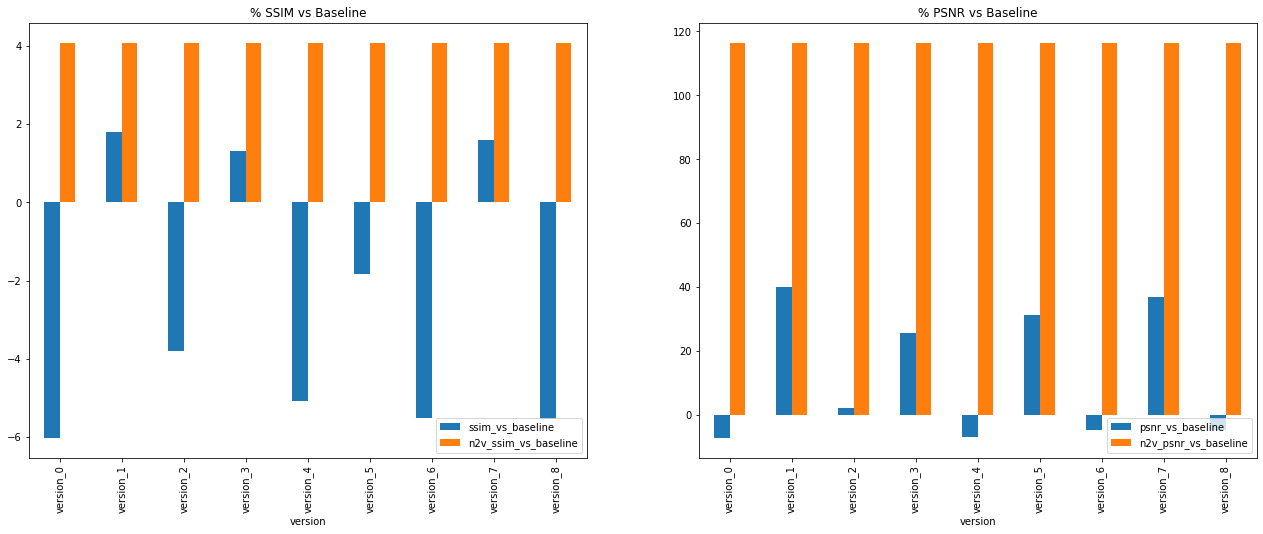

In [47]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(22, 8))
data_log[['version', 'ssim_vs_baseline', 'n2v_ssim_vs_baseline']].plot.bar(x='version', ax=ax0)
ax0.set_title('% SSIM vs Baseline')
ax0.legend(loc='lower right')

data_log[['version', 'psnr_vs_baseline', 'n2v_psnr_vs_baseline']].plot.bar(x='version', ax=ax1)
ax1.set_title('% PSNR vs Baseline')
ax1.legend(loc='lower right')

## Normal vs Deconvolved with Gauss + Poiss + Perlin

In [40]:
logdir = 'data/S2SDenoising/tryout_model_logs/tomoPhantom_model14_noisyGaussPoissPerlin/normal_vs_deconvolved_comparison/'
logdir = os.path.join(PARENT_PATH, logdir)

data_log = logdir_to_dataframe(logdir)
data_log

,model,version,dataset,TV_alpha,Version_comment,transform,full_tomo_psnr,full_tomo_ssim,baseline_psnr,baseline_ssim,tomo_path,gt_tomo_path,use_deconv_as_target,predict_simRecon,use_deconv_data,n2v_psnr,n2v_ssim,baseline_psnr_best,baseline_ssim_best,ssim_vs_baseline,n2v_ssim_vs_baseline,psnr_vs_baseline,n2v_psnr_vs_baseline
1,normal_vs_deconvolved_comparison,version_0,singleCET_dataset,0,Deconvolved bernoulli,{'p': '0.5'},11.8060,0.8935,11.7780,0.8942,tomoPhantom_model14_noisyGaussPoissPerlin.mrc,tomoPhantom_model14.mrc,null,null,true,16.9207,0.9507,12.7716,0.9479,-5.7413,0.2913,-7.5602,32.4867
2,normal_vs_deconvolved_comparison,version_1,singleCET_dataset,0,Bernoull,{'p': '0.5'},16.9301,0.9635,12.7716,0.9479,tomoPhantom_model14_noisyGaussPoissPerlin.mrc,tomoPhantom_model14.mrc,null,null,false,16.9207,0.9507,12.7716,0.9479,1.6494,0.2913,32.5607,32.4867
8,normal_vs_deconvolved_comparison,version_2,singleCET_FourierDataset,0,Deconvolved Fourier,{'p': '0.5'},12.9671,0.9154,11.7780,0.8942,tomoPhantom_model14_noisyGaussPoissPerlin.mrc,tomoPhantom_model14.mrc,null,null,true,16.9207,0.9507,12.7716,0.9479,-3.4271,0.2913,1.5308,32.4867
6,normal_vs_deconvolved_comparison,version_3,singleCET_FourierDataset,0,Fourier,{'p': '0.5'},15.9272,0.9657,12.7716,0.9479,tomoPhantom_model14_noisyGaussPoissPerlin.mrc,tomoPhantom_model14.mrc,null,null,false,16.9207,0.9507,12.7716,0.9479,1.8787,0.2913,24.7079,32.4867
5,normal_vs_deconvolved_comparison,version_4,singleCET_ProjectedDataset,0,Sim N2N denoising using deconv reconstruction ...,{'p': '0.5'},11.9105,0.9038,12.7716,0.9479,tomoPhantom_model14_noisyGaussPoissPerlin.mrc,tomoPhantom_model14.mrc,true,true,true,16.9207,0.9507,12.7716,0.9479,-4.6529,0.2913,-6.7423,32.4867
7,normal_vs_deconvolved_comparison,version_5,singleCET_ProjectedDataset,0,Sim N2N denoising using reconstruction as target.,{'p': '0.5'},16.5386,0.9410,12.7716,0.9479,tomoPhantom_model14_noisyGaussPoissPerlin.mrc,tomoPhantom_model14.mrc,false,true,true,16.9207,0.9507,12.7716,0.9479,-0.7222,0.2913,29.4953,32.4867
0,normal_vs_deconvolved_comparison,version_6,singleCET_ProjectedDataset,0,Sim N2N denoising using deconv data as target.,{'p': '0.5'},12.2595,0.9003,11.7780,0.8942,tomoPhantom_model14_noisyGaussPoissPerlin.mrc,tomoPhantom_model14.mrc,true,false,true,16.9207,0.9507,12.7716,0.9479,-5.0239,0.2913,-4.0098,32.4867
3,normal_vs_deconvolved_comparison,version_7,singleCET_ProjectedDataset,0,Sim N2N denoising using raw data as target.,{'p': '0.5'},16.8452,0.9640,12.7716,0.9479,tomoPhantom_model14_noisyGaussPoissPerlin.mrc,tomoPhantom_model14.mrc,false,false,true,16.9207,0.9507,12.7716,0.9479,1.6940,0.2913,31.8960,32.4867
4,normal_vs_deconvolved_comparison,version_8,singleCET_ProjectedDataset,0,Sim N2N denoising using deconvolved data as ta...,{'p': '0.5'},12.2367,0.8999,11.7780,0.8942,tomoPhantom_model14_noisyGaussPoissPerlin.mrc,tomoPhantom_model14.mrc,true,false,true,16.9207,0.9507,12.7716,0.9479,-5.0682,0.2913,-4.1879,32.4867


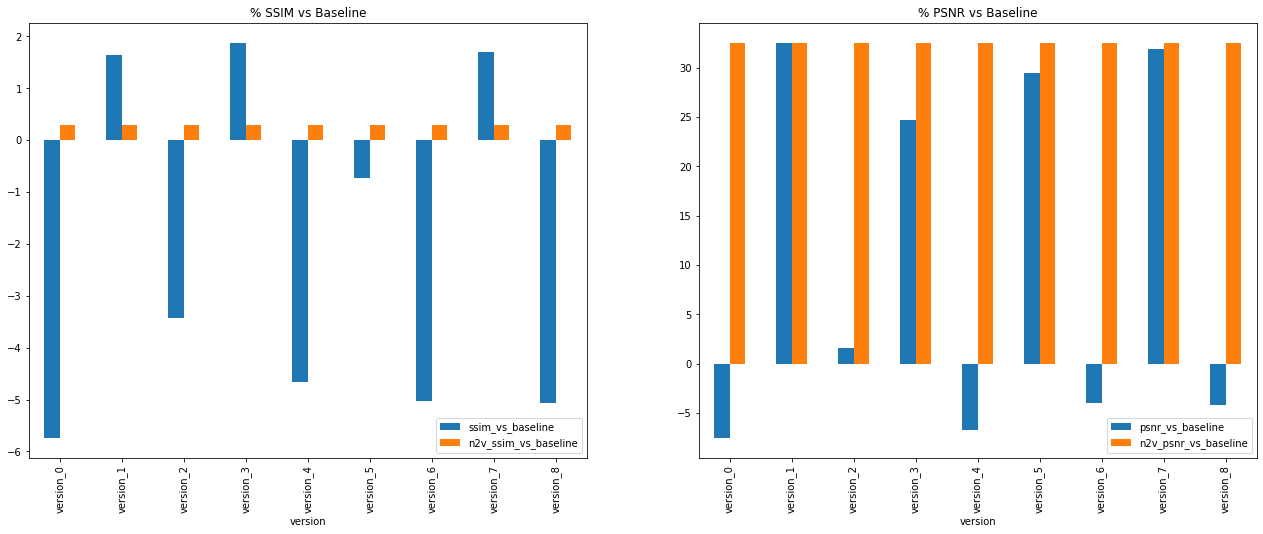

In [41]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(22, 8))
data_log[['version', 'ssim_vs_baseline', 'n2v_ssim_vs_baseline']].plot.bar(x='version', ax=ax0)
ax0.set_title('% SSIM vs Baseline')
ax0.legend(loc='lower right')

data_log[['version', 'psnr_vs_baseline', 'n2v_psnr_vs_baseline']].plot.bar(x='version', ax=ax1)
ax1.set_title('% PSNR vs Baseline')
ax1.legend(loc='lower right')

# Tomo02 Dummy

## Denoising noisy cryoCARE Gaussian + Poisson

In [48]:
logdir = 'data/S2SDenoising/tryout_model_logs/tomo02_cryoCAREDummy_noisyGaussPoiss/normal_vs_deconvolved_comparison/'
logdir = os.path.join(PARENT_PATH, logdir)

data_log = logdir_to_dataframe(logdir, ignore_deconv=False)
data_log

,model,version,dataset,TV_alpha,Version_comment,transform,full_tomo_psnr,full_tomo_ssim,baseline_psnr,baseline_ssim,tomo_path,gt_tomo_path,use_deconv_as_target,predict_simRecon,use_deconv_data,n2v_psnr,n2v_ssim,baseline_psnr_best,baseline_ssim_best,ssim_vs_baseline,n2v_ssim_vs_baseline,psnr_vs_baseline,n2v_psnr_vs_baseline
1,normal_vs_deconvolved_comparison,version_0,singleCET_dataset,0,Deconvolved bernoulli,{'p': '0.5'},16.9253,0.9715,17.0581,0.9724,tomo02_cryoCAREDummy_noisyGaussPoiss.mrc,tomo02_cryoCAREDummy.mrc,null,null,true,16.9223,0.9832,17.0581,0.9724,-0.0882,1.1121,-0.7787,-0.7962
2,normal_vs_deconvolved_comparison,version_1,singleCET_dataset,0,Bernoull,{'p': '0.5'},18.3483,0.9811,14.6901,0.9670,tomo02_cryoCAREDummy_noisyGaussPoiss.mrc,tomo02_cryoCAREDummy.mrc,null,null,false,19.3782,0.9887,17.0581,0.9724,0.8935,1.6801,7.5633,13.6012
8,normal_vs_deconvolved_comparison,version_2,singleCET_FourierDataset,0,Deconvolved Fourier,{'p': '0.5'},17.7594,0.9814,17.0581,0.9724,tomo02_cryoCAREDummy_noisyGaussPoiss.mrc,tomo02_cryoCAREDummy.mrc,null,null,true,16.9223,0.9832,17.0581,0.9724,0.9240,1.1121,4.1111,-0.7962
6,normal_vs_deconvolved_comparison,version_3,singleCET_FourierDataset,0,Fourier,{'p': '0.5'},16.8012,0.9759,14.6901,0.9670,tomo02_cryoCAREDummy_noisyGaussPoiss.mrc,tomo02_cryoCAREDummy.mrc,null,null,false,19.3782,0.9887,17.0581,0.9724,0.3601,1.6801,-1.5060,13.6012
5,normal_vs_deconvolved_comparison,version_4,singleCET_ProjectedDataset,0,Sim N2N denoising using deconv reconstruction ...,{'p': '0.5'},14.7219,0.9204,14.6901,0.9670,tomo02_cryoCAREDummy_noisyGaussPoiss.mrc,tomo02_cryoCAREDummy.mrc,true,true,true,16.9223,0.9832,17.0581,0.9724,-5.3485,1.1121,-13.6956,-0.7962
7,normal_vs_deconvolved_comparison,version_5,singleCET_ProjectedDataset,0,Sim N2N denoising using reconstruction as target.,{'p': '0.5'},14.3661,0.9115,14.6901,0.9670,tomo02_cryoCAREDummy_noisyGaussPoiss.mrc,tomo02_cryoCAREDummy.mrc,false,true,true,16.9223,0.9832,17.0581,0.9724,-6.2592,1.1121,-15.7816,-0.7962
0,normal_vs_deconvolved_comparison,version_6,singleCET_ProjectedDataset,0,Sim N2N denoising using deconv data as target.,{'p': '0.5'},16.8605,0.9726,17.0581,0.9724,tomo02_cryoCAREDummy_noisyGaussPoiss.mrc,tomo02_cryoCAREDummy.mrc,true,false,true,16.9223,0.9832,17.0581,0.9724,0.0190,1.1121,-1.1588,-0.7962
3,normal_vs_deconvolved_comparison,version_7,singleCET_ProjectedDataset,0,Sim N2N denoising using raw data as target.,{'p': '0.5'},17.7832,0.9784,14.6901,0.9670,tomo02_cryoCAREDummy_noisyGaussPoiss.mrc,tomo02_cryoCAREDummy.mrc,false,false,true,16.9223,0.9832,17.0581,0.9724,0.6157,1.1121,4.2505,-0.7962
4,normal_vs_deconvolved_comparison,version_8,singleCET_ProjectedDataset,0,Sim N2N denoising using deconvolved data as ta...,{'p': '0.5'},16.8741,0.9726,17.0581,0.9724,tomo02_cryoCAREDummy_noisyGaussPoiss.mrc,tomo02_cryoCAREDummy.mrc,true,false,true,16.9223,0.9832,17.0581,0.9724,0.0198,1.1121,-1.0791,-0.7962


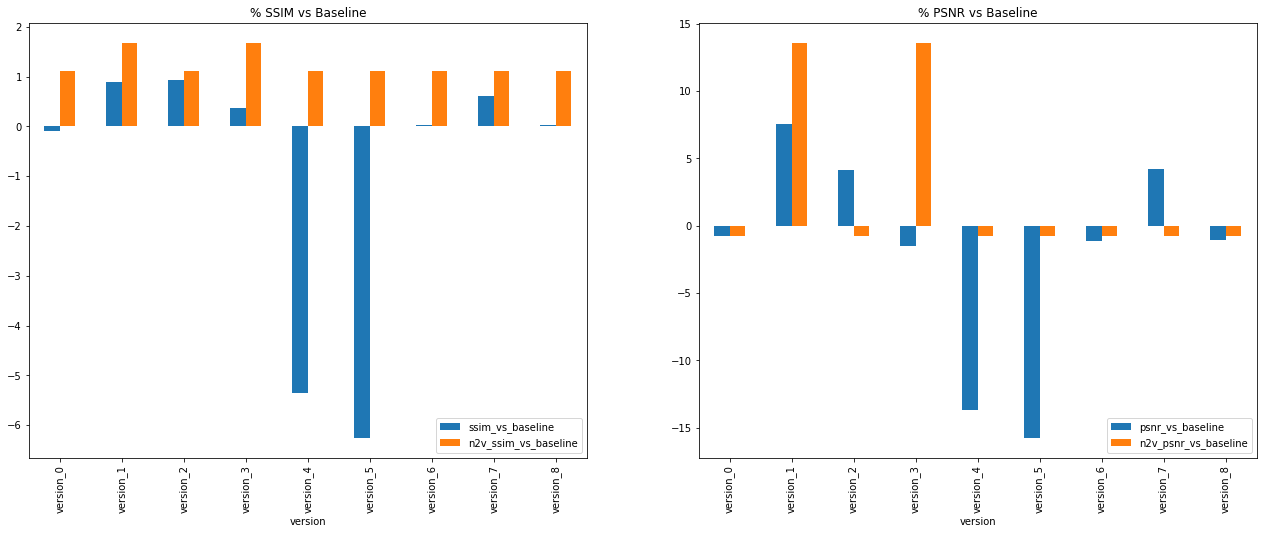

In [49]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(22, 8))
data_log[['version', 'ssim_vs_baseline', 'n2v_ssim_vs_baseline']].plot.bar(x='version', ax=ax0)
ax0.set_title('% SSIM vs Baseline')
ax0.legend(loc='lower right')

data_log[['version', 'psnr_vs_baseline', 'n2v_psnr_vs_baseline']].plot.bar(x='version', ax=ax1)
ax1.set_title('% PSNR vs Baseline')
ax1.legend(loc='lower right')

## Denoising noisy cryoCARE Gaussian + Poisson + Perlin

In [44]:
logdir = 'data/S2SDenoising/tryout_model_logs/tomo02_cryoCAREDummy_noisyGaussPoissPerlin/normal_vs_deconvolved_comparison/'
logdir = os.path.join(PARENT_PATH, logdir)

data_log = logdir_to_dataframe(logdir, ignore_deconv=False)
data_log

,model,version,dataset,TV_alpha,Version_comment,transform,full_tomo_psnr,full_tomo_ssim,baseline_psnr,baseline_ssim,tomo_path,gt_tomo_path,use_deconv_as_target,predict_simRecon,use_deconv_data,n2v_psnr,n2v_ssim,baseline_psnr_best,baseline_ssim_best,ssim_vs_baseline,n2v_ssim_vs_baseline,psnr_vs_baseline,n2v_psnr_vs_baseline
1,normal_vs_deconvolved_comparison,version_0,singleCET_dataset,0,Deconvolved bernoulli,{'p': '0.5'},16.6916,0.9660,16.7826,0.9665,tomo02_cryoCAREDummy_noisyGaussPoissPerlin.mrc,tomo02_cryoCAREDummy.mrc,null,null,true,16.1472,0.9292,16.7826,0.9665,-0.0521,-3.8569,-0.5423,-3.7861
2,normal_vs_deconvolved_comparison,version_1,singleCET_dataset,0,Bernoull,{'p': '0.5'},17.4948,0.9676,14.5724,0.9558,tomo02_cryoCAREDummy_noisyGaussPoissPerlin.mrc,tomo02_cryoCAREDummy.mrc,null,null,false,16.1472,0.9292,16.7826,0.9665,0.1170,-3.8569,4.2435,-3.7861
8,normal_vs_deconvolved_comparison,version_2,singleCET_FourierDataset,0,Deconvolved Fourier,{'p': '0.5'},17.5534,0.9776,16.7826,0.9665,tomo02_cryoCAREDummy_noisyGaussPoissPerlin.mrc,tomo02_cryoCAREDummy.mrc,null,null,true,16.1472,0.9292,16.7826,0.9665,1.1492,-3.8569,4.5928,-3.7861
6,normal_vs_deconvolved_comparison,version_3,singleCET_FourierDataset,0,Fourier,{'p': '0.5'},16.5532,0.9665,14.5724,0.9558,tomo02_cryoCAREDummy_noisyGaussPoissPerlin.mrc,tomo02_cryoCAREDummy.mrc,null,null,false,16.1472,0.9292,16.7826,0.9665,0.0034,-3.8569,-1.3669,-3.7861
5,normal_vs_deconvolved_comparison,version_4,singleCET_ProjectedDataset,0,Sim N2N denoising using deconv reconstruction ...,{'p': '0.5'},13.4409,0.8974,14.5724,0.9558,tomo02_cryoCAREDummy_noisyGaussPoissPerlin.mrc,tomo02_cryoCAREDummy.mrc,true,true,true,16.1472,0.9292,16.7826,0.9665,-7.1464,-3.8569,-19.9120,-3.7861
7,normal_vs_deconvolved_comparison,version_5,singleCET_ProjectedDataset,0,Sim N2N denoising using reconstruction as target.,{'p': '0.5'},12.8856,0.8640,14.5724,0.9558,tomo02_cryoCAREDummy_noisyGaussPoissPerlin.mrc,tomo02_cryoCAREDummy.mrc,false,true,true,16.1472,0.9292,16.7826,0.9665,-10.6060,-3.8569,-23.2208,-3.7861
0,normal_vs_deconvolved_comparison,version_6,singleCET_ProjectedDataset,0,Sim N2N denoising using deconv data as target.,{'p': '0.5'},16.5844,0.9669,16.7826,0.9665,tomo02_cryoCAREDummy_noisyGaussPoissPerlin.mrc,tomo02_cryoCAREDummy.mrc,true,false,true,16.1472,0.9292,16.7826,0.9665,0.0428,-3.8569,-1.1811,-3.7861
3,normal_vs_deconvolved_comparison,version_7,singleCET_ProjectedDataset,0,Sim N2N denoising using raw data as target.,{'p': '0.5'},17.1505,0.9664,14.5724,0.9558,tomo02_cryoCAREDummy_noisyGaussPoissPerlin.mrc,tomo02_cryoCAREDummy.mrc,false,false,true,16.1472,0.9292,16.7826,0.9665,-0.0078,-3.8569,2.1919,-3.7861
4,normal_vs_deconvolved_comparison,version_8,singleCET_ProjectedDataset,0,Sim N2N denoising using deconvolved data as ta...,{'p': '0.5'},16.5767,0.9669,16.7826,0.9665,tomo02_cryoCAREDummy_noisyGaussPoissPerlin.mrc,tomo02_cryoCAREDummy.mrc,true,false,true,16.1472,0.9292,16.7826,0.9665,0.0396,-3.8569,-1.2274,-3.7861


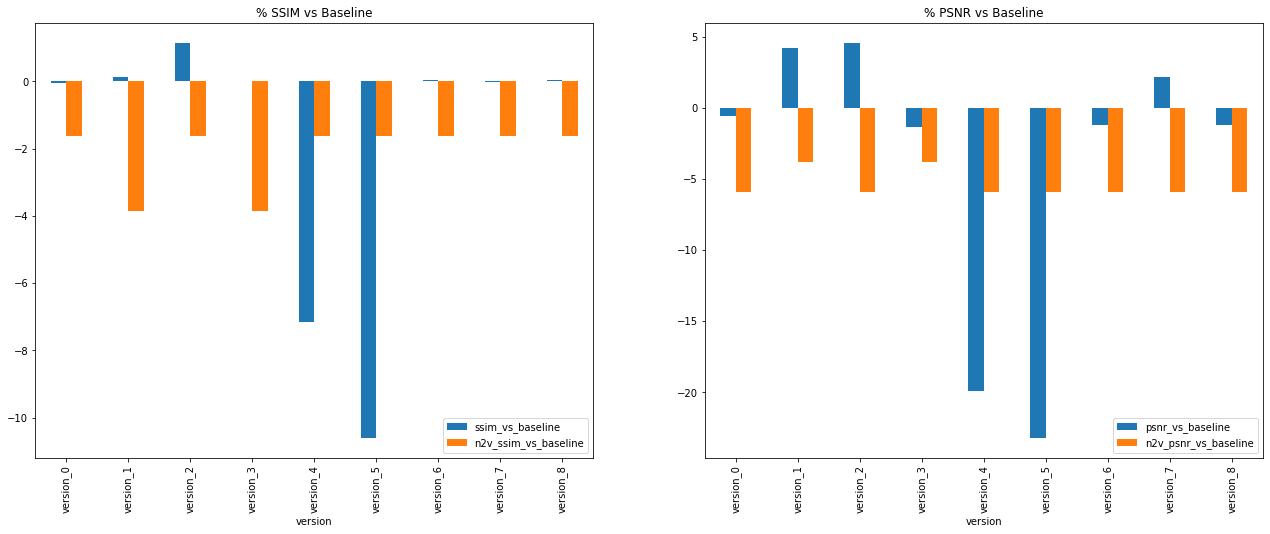

In [43]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(22, 8))
data_log[['version', 'ssim_vs_baseline', 'n2v_ssim_vs_baseline']].plot.bar(x='version', ax=ax0)
ax0.set_title('% SSIM vs Baseline')
ax0.legend(loc='lower right')

data_log[['version', 'psnr_vs_baseline', 'n2v_psnr_vs_baseline']].plot.bar(x='version', ax=ax1)
ax1.set_title('% PSNR vs Baseline')
ax1.legend(loc='lower right')